### 1. Download and Process the Books Dataset

In [1]:
from datasets import load_dataset

# Load the Books reviews dataset
dataset = load_dataset("cogsci13/Amazon-Reviews-2023-Books-Review", "default", trust_remote_code=True)


Resolving data files:   0%|          | 0/33 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/33 [00:00<?, ?it/s]

In [2]:
import pandas as pd

# Extract relevant fields
df = pd.DataFrame({
    'user_id': dataset['full']['user_id'],
    'item_id': dataset['full']['parent_asin'],
    'rating': dataset['full']['rating'],
    'timestamp': dataset['full']['timestamp']
})

### 2. Train-test Split Procedure
#### a) Randomly select 20% of all interactions
- Simple to implement.
- Ensures a representative sample of the entire dataset.
- May lead to data leakage if future interactions are included in the training set.
- Not ideal for time-sensitive models.

#### b) Select 20% interactions for each user at random
- Maintains user interaction distribution.
- Potential for data leakage.

#### c) Select the most recent 20% interactions for each user
- Mimics real-world scenarios where models predict future interactions.
- Prevents data leakage.
- Users with fewer interactions may have insufficient training data.
- Assumes chronological order is meaningful.

#### d) Select a fixed number of the most recent interactions for each user to obtain around 20% of the data
<!-- - Ensures each user contributes to the test set.
- Balances the dataset if user interactions vary widely.
- May not precisely achieve a 20% split.
- Users with minimal interactions may be excluded. -->
???

#### e) Select the most recent 20% of all interactions
- Reflects a real-world temporal split.
- Useful for evaluating model performance over time.
- Users with no recent interactions are excluded from the test set.
- May not capture long-term user preferences.



### 3. Basic Data Analysis Plots

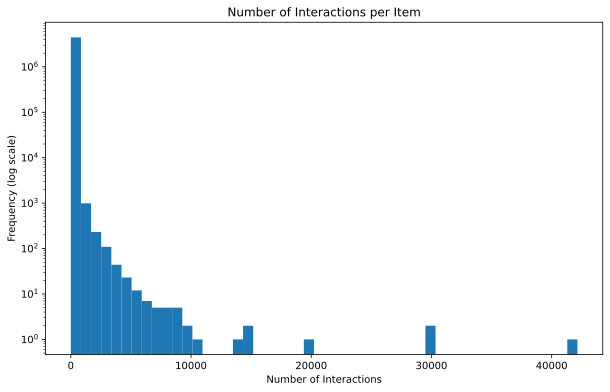

In [3]:
# Number of interactions per item
import matplotlib.pyplot as plt

item_counts = df['item_id'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(item_counts, bins=50, log=True)
plt.title('Number of Interactions per Item')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency (log scale)')
plt.show()


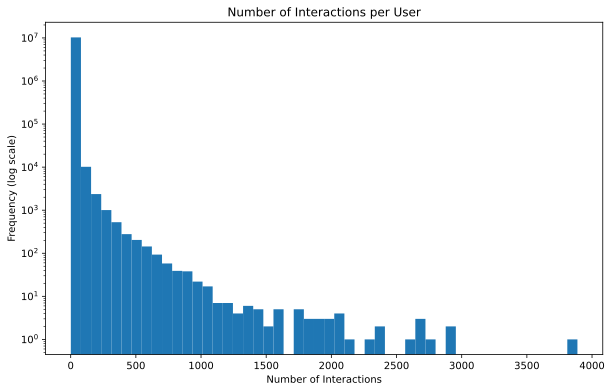

In [4]:
# Distribution of users’ number of interactions
user_counts = df['user_id'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(user_counts, bins=50, log=True)
plt.title('Number of Interactions per User')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency (log scale)')
plt.show()


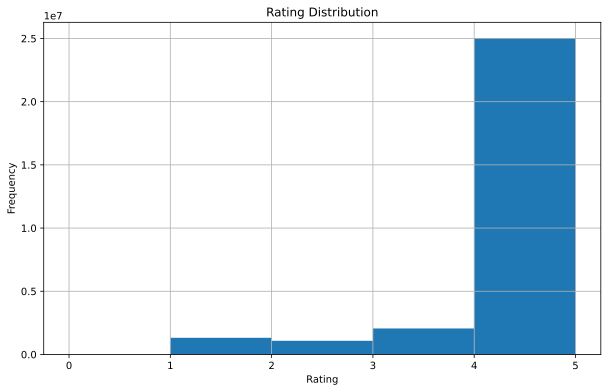

In [5]:
# Rating Distribution
plt.figure(figsize=(10, 6))
df['rating'].hist(bins=5)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


/tmp/ipykernel_5744/4257465126.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M').size().plot(figsize=(12, 6))


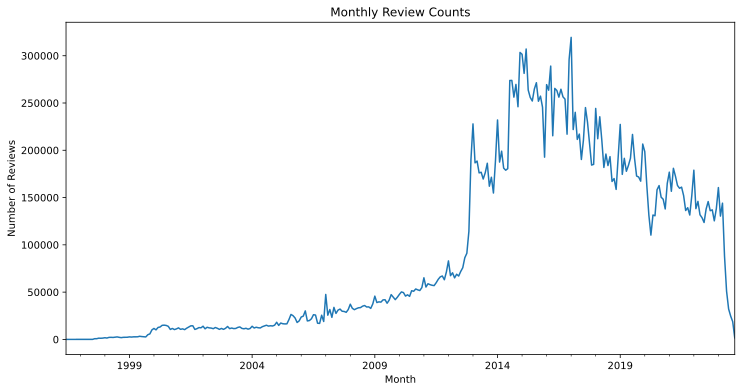

In [6]:
# Temporal Distribution of Reviews
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)
df.resample('M').size().plot(figsize=(12, 6))
plt.title('Monthly Review Counts')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()


### 4. Train-Test Split: Two Most Recent Items per User for Testing

In [ ]:
# df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df_sorted = df.sort_values(by=['user_id', 'timestamp'])
test_df = df_sorted.groupby('user_id').tail(2)
train_df = df_sorted.drop(test_df.index)

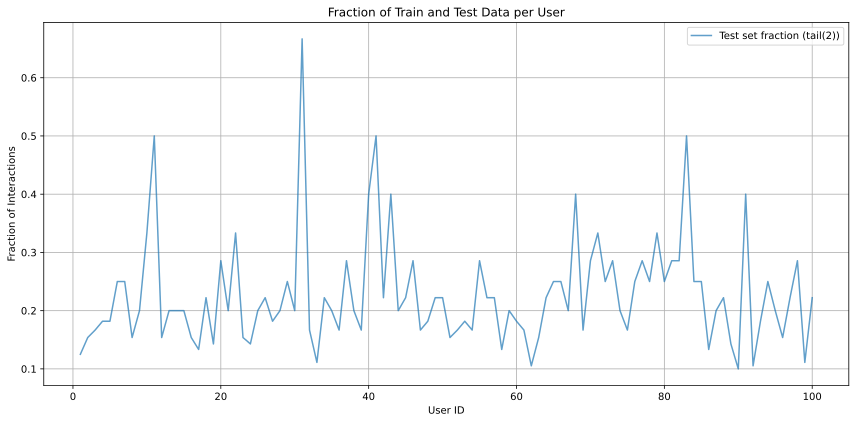

In [11]:
# Compute fractions instead of absolute counts
user_total = df['user_id'].value_counts().sort_index()
user_train = train_df['user_id'].value_counts().sort_index()
user_test = test_df['user_id'].value_counts().sort_index()

# Align indices to avoid NaNs
user_ids = sorted(df['user_id'].unique())
train_frac = user_train.reindex(user_ids, fill_value=0) / user_total.reindex(user_ids, fill_value=1)
test_frac = user_test.reindex(user_ids, fill_value=0) / user_total.reindex(user_ids, fill_value=1)

# Plot fractions
plt.figure(figsize=(12, 6))
plt.plot(user_ids, test_frac.values, label='Test set fraction (tail(2))', alpha=0.7)
plt.xlabel('User ID')
plt.ylabel('Fraction of Interactions')
plt.title('Fraction of Train and Test Data per User')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
